<a href="https://colab.research.google.com/github/Ron-Maina/Deep_Convolutional_Neural_Networks_for_Image_Classification/blob/main/Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 2: Transformers

**Objective:** The objective of this section is to implement transformer by given description. Training is NOT required.

**Tasks:**
To complete this assignment, please submit a single notebook that includes the implementation and outputs of the following steps. Please ensure that the notebook retain the outputs. Failure to do so will result in zero marks for the corresponding steps in which no output is displayed.

**1. Implement the given Transformer architecture (Self-Attention Blocks and FeedForward Networks only). Training is not needed. (20 points)**
*  In Self-Attention Blocks, there are 12 attention heads and 64 head dimension. In FeedForward Networks, the hidden dimensions are 4 times of input dimensions.
*  The input token shape is [batch, num_tokens, dim]
*  Use pre layer normalization in each block
*  Use GeLU activation function in the FeedForward Networks


In [ ]:
#Step 1 implementation
import torch
import torch.nn as nn
import math

class MultiHeadSelfAttention(nn.Module):
    """
    Multi-Head Self-Attention mechanism
    """
    def __init__(self, dim, num_heads=12, head_dim=64):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = head_dim
        self.inner_dim = num_heads * head_dim
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, self.inner_dim * 3, bias=False)

        self.proj_out = nn.Linear(self.inner_dim, dim)

    def forward(self, x):
        batch_size, num_tokens, dim = x.shape

        qkv = self.qkv(x)
        qkv = qkv.reshape(batch_size, num_tokens, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        # Compute attention scores
        attn_scores = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        attn_probs = torch.softmax(attn_scores, dim=-1)

        # Apply attention to values
        attn_output = torch.matmul(attn_probs, v)

        # Reshape and project output
        attn_output = attn_output.transpose(1, 2).reshape(batch_size, num_tokens, self.inner_dim)
        output = self.proj_out(attn_output)

        return output


class FeedForward(nn.Module):
    """
    Feed-Forward Network with hidden dimension 4x input dimension
    """
    def __init__(self, dim, hidden_dim_multiplier=4):
        super().__init__()
        hidden_dim = dim * hidden_dim_multiplier

        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim)
        )

    def forward(self, x):
        return self.net(x)


class TransformerBlock(nn.Module):
    """
    Transformer Block with Pre-Layer Normalization
    """
    def __init__(self, dim, num_heads=12, head_dim=64):
        super().__init__()

        self.norm1 = nn.LayerNorm(dim)
        self.attn = MultiHeadSelfAttention(dim, num_heads, head_dim)

        self.norm2 = nn.LayerNorm(dim)
        self.ffn = FeedForward(dim)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))

        x = x + self.ffn(self.norm2(x))

        return x


class Transformer(nn.Module):
    """
    Complete Transformer with multiple blocks
    """
    def __init__(self, dim, depth, num_heads=12, head_dim=64):
        super().__init__()

        self.blocks = nn.ModuleList([
            TransformerBlock(dim, num_heads, head_dim)
            for _ in range(depth)
        ])

        # Final layer norm
        self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        for block in self.blocks:
            x = block(x)

        x = self.norm(x)
        return x




# ============================================================
#  Model Summary Table
# ============================================================
def model_summary(model, input_size):
    summary = []
    hooks = []

    def register_hook(module):
        if not list(module.children()):
            def hook(module, inp, out):
                layer_name = module.__class__.__name__
                idx = len(summary) + 1

                if isinstance(out, (tuple, list)):
                    out_shape = tuple(out[0].size())
                else:
                    out_shape = tuple(out.size())

                params = sum(p.numel() for p in module.parameters())

                summary.append([
                    f"{layer_name}-{idx}",
                    str(out_shape),
                    params
                ])
            hooks.append(module.register_forward_hook(hook))

    model.apply(register_hook)

    x = torch.randn(*input_size)
    model.eval()
    with torch.no_grad():
        model(x)

    for h in hooks:
        h.remove()

    # Print summary table
    print("\nModel: \"Transformer\"")
    print("=" * 80)
    print(f"{'Layer (type)':<35} {'Output Shape':<25} {'Param #':>12}")
    print("=" * 80)

    total_params = 0
    for layer in summary:
        total_params += layer[2]
        print(f"{layer[0]:<35} {layer[1]:<25} {layer[2]:>12}")

    trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad
    )

    print("=" * 80)
    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {trainable_params:,}")
    print(f"Non-trainable params: {total_params - trainable_params:,}")
    print("=" * 80)

# ============================================================
# Step 7: Test & Run
# ============================================================
batch_size = 2
num_tokens = 10
dim = 768
depth = 6

print("\nTest Configuration")
print(f"Batch size: {batch_size}")
print(f"Tokens: {num_tokens}")
print(f"Embedding dim: {dim}")
print(f"Transformer blocks: {depth}")

model = Transformer(dim=dim, depth=depth, num_heads=12, head_dim=64)

x = torch.randn(batch_size, num_tokens, dim)
print(f"\nInput shape: {x.shape}")

with torch.no_grad():
    output = model(x)

print(f"Output shape: {output.shape}")

# Print Keras-style summary table
model_summary(model, (batch_size, num_tokens, dim))


Test Configuration
Batch size: 2
Tokens: 10
Embedding dim: 768
Transformer blocks: 6

Input shape: torch.Size([2, 10, 768])
Output shape: torch.Size([2, 10, 768])

Model: "Transformer"
Layer (type)                        Output Shape                   Param #
LayerNorm-1                         (2, 10, 768)                      1536
Linear-2                            (2, 10, 2304)                  1769472
Linear-3                            (2, 10, 768)                    590592
LayerNorm-4                         (2, 10, 768)                      1536
Linear-5                            (2, 10, 3072)                  2362368
GELU-6                              (2, 10, 3072)                        0
Linear-7                            (2, 10, 768)                   2360064
LayerNorm-8                         (2, 10, 768)                      1536
Linear-9                            (2, 10, 2304)                  1769472
Linear-10                           (2, 10, 768)                

**2. Visualize your architecture. (10 points)**
* Draw the architecture diagram of the Transformer and save as "transformer.png".

> Step 2 Visualization
>
> <img src='transformer.png' alt='student transformer'>

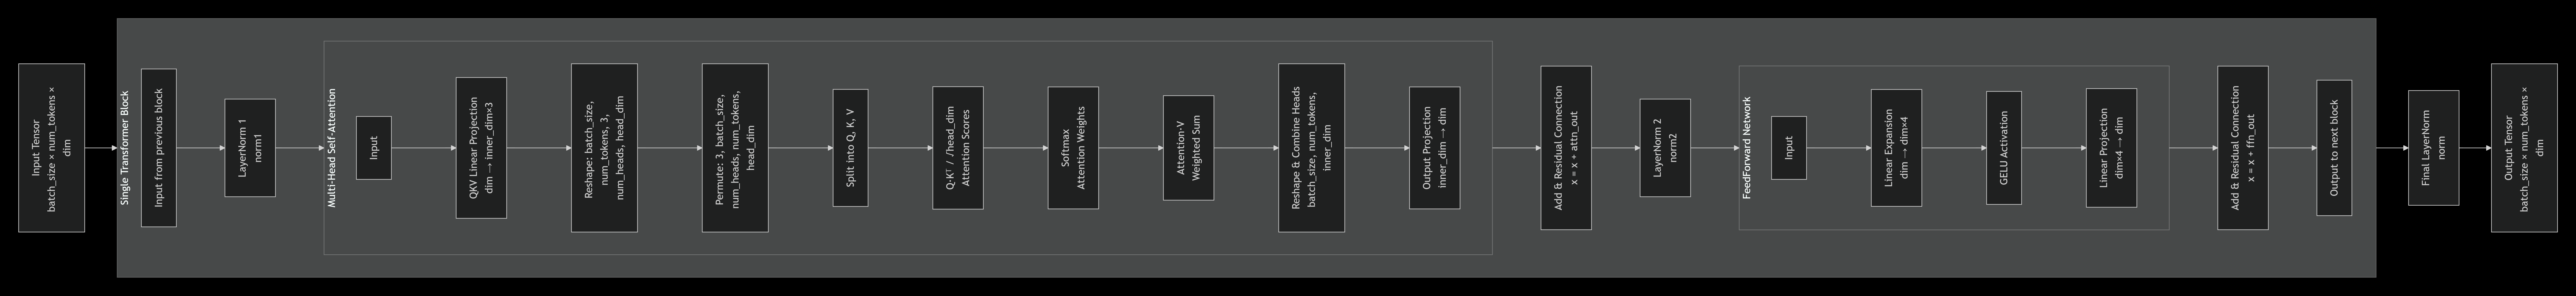

In [ ]:
from IPython.display import Image, display
display(Image('/content/transformer.png'))